<a href="https://colab.research.google.com/github/salarbalou/Data_Analysis_Projects/blob/main/FM_Process_Scale_Up_Continuous_Solvent_Extraction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ======================================================================
# Natural Rubber Extraction in Crown Model III Continuous Extractor
# Stagewise Counter-Current Simulation (Python for Google Colab)
# ======================================================================

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
N = 6
y = np.zeros((2,N))
x_s = y[0:N]           # solids composition along bed
C_l = y[N:2*N]         # liquid concentration along bed

In [ ]:

# We will use the Stagewise or 1-D axial model to solven this problem.
# for the Crowns Model 3 extractor - this will be a Stagewise Counter-current extractor model.
# for the  mass transfer, we use  a linear driving-force (LDF) mass-transfer model between solids and liquids.

dx=0.667 m, V_liq_stage=0.1667 m³, M_s_stage=80.00 kg
Initial rubber (kg): 14.400
Final rubber in solids (kg): 1.265
Extracted rubber (kg): 13.135
Extraction fraction: 91.21%


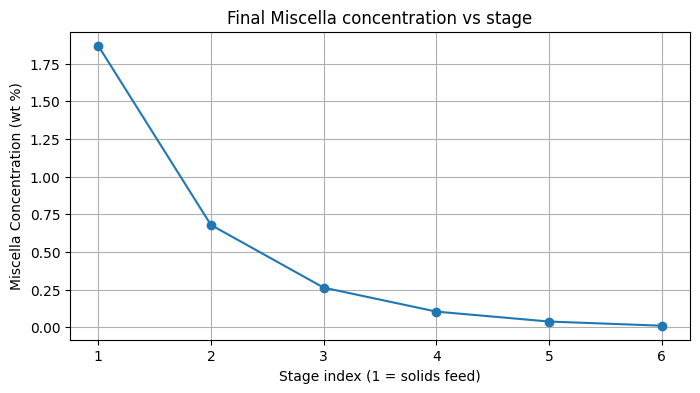

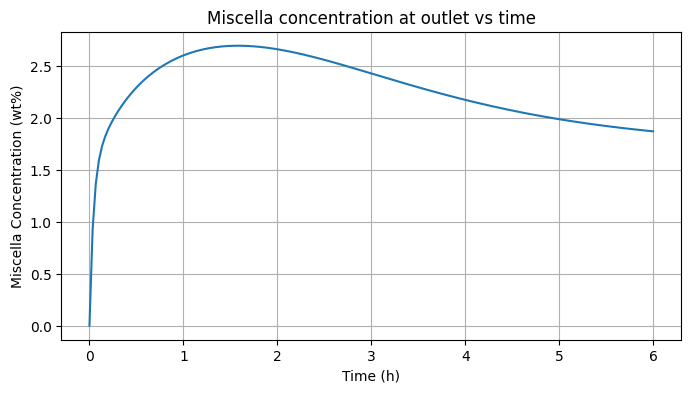

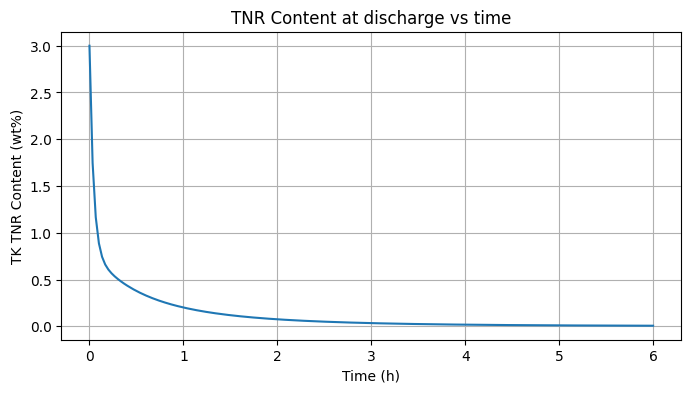

In [48]:
#Unit Parameters
N = 6                 # number of discretized "stages" along the extractor length
L = 4.0                   # extractor total length in meters
A = 0.5                   # cross-sectional area of bed [m^2]


#Feed Patrameters
eps = 0.5            # void fraction of TK
rho_s_bulk = 480.0        # bulk density of dry solid bed [kg/m^3] (includes porosity of particles + packing)

QOO = 2                   # solvent volumetric flowrate (drum of hexane/hr)
QO = QOO* 0.2                  # solvent volumetric flowrate (~0.2 m^3/hr or 1 drum of hexane/hr)
Q = QO*0.0002777778       # solvent volumetric flowrate [m^3/s]

Mdot_s = 150.0/3600.0      # dry solids feed rate [kg/s] (300 kg/h feed throughput)
x_feed = 0.03             # mass fraction of rubber in fresh solids (3% dry weight typical for TKS roots)
C_liq_inlet = 0.0         # concentration of rubber in fresh hexane solvent entering [kg/m^3]
x_s_feed_incoming = x_feed # solids entering always start at initial feed composition

# Mass transfer & equilibrium parameters (determined via FM's Batch Pilot and Lab Experiments)
k_a = 5e-3              # overall mass transfer coefficient [1/s] - measured from the slope of Cl vs time
K_eq = 6.5e-4            # equilibrium partition coefficient (relating to affinity of TNR to stay in solid vs liquid) [m^3/kg]


# Derived quantities (geometry of each "stage")
dx = L / N                               # length of each stage [m]
V_liq_stage = eps * A * dx           # liquid volume per stage [m^3]
V_solid_stage = (1 - eps) * A * dx   # solid bed volume per stage [m^3]
M_s_stage = rho_s_bulk * V_solid_stage   # dry solid mass per stage [kg]

print(f"dx={dx:.3f} m, V_liq_stage={V_liq_stage:.4f} m³, M_s_stage={M_s_stage:.2f} kg")

# ------------------- MODEL ODE SYSTEM -------------------
def odes(t, y):
    """
    y contains:
      - first N entries: x_s[j] = rubber mass fraction in solids at stage j [kg/kg dry solid]
      - next N entries: C_l[j] = rubber concentration in liquid at stage j [kg/m^3]
    Returns time derivatives (dx/dt, dC/dt) for all stages.
    """
    x_s = y[0:N]           # solids composition along bed
    C_l = y[N:2*N]         # liquid concentration along bed

    dxdt = np.zeros_like(x_s)  # time derivatives for solids
    dCdt = np.zeros_like(C_l)  # time derivatives for liquid

    # convective turnover terms (residence effects)
    conv_s_factor = Mdot_s / M_s_stage   # how fast solids are replaced in each stage [1/s]
    conv_l_factor = Q / V_liq_stage      # how fast liquid is replaced in each stage [1/s]

    for j in range(N):
        # Solids convective inlet: stage 0 fed with fresh solids, others fed from previous stage
        x_prev = x_s_feed_incoming if j == 0 else x_s[j-1]

        # Liquid convective inlet: countercurrent, so last stage fed by fresh solvent
        C_next = C_liq_inlet if j == N-1 else C_l[j+1]

        # Mass transfer rate between solid and liquid (kg/s per stage)
        # Uses linear driving force: proportional to difference (solid conc - equilibrium with liquid conc)
        r_j = k_a * M_s_stage * ( x_s[j] - K_eq * C_l[j] )

        # Solids mass balance: extraction lowers x_s, plus solids replacement by convective flow
        dxdt[j] = - r_j / M_s_stage + conv_s_factor * (x_prev - x_s[j])

        # Liquid mass balance: extraction increases C_l, plus convective mixing from upstream liquid
        dCdt[j] = conv_l_factor * (C_next - C_l[j]) + r_j / V_liq_stage

    return np.concatenate([dxdt, dCdt])   # combine into one vector

# ------------------- INITIAL CONDITIONS -------------------
# At t=0, all solids have full rubber fraction (x_feed), all liquid is fresh (C=0)
y0 = np.concatenate([ np.full(N, x_feed), np.zeros(N) ])

# integrate dynamics for 6 hours (in seconds)
t_final = 6 * 3600.0
t_eval = np.linspace(0, t_final, 180)  # sample 30 min or 180s time points

# Solve ODE system using implicit BDF solver (good for stiff equations)
sol = solve_ivp(odes, (0, t_final), y0, t_eval=t_eval, method='BDF', atol=1e-8, rtol=1e-6)

if not sol.success:
    raise RuntimeError("ODE integration failed: " + sol.message)

# ------------------- RESULTS -------------------
x_s_final = sol.y[0:N, -1]       # final solids fraction profile across stages
C_l_final = sol.y[N:2*N, -1]     # final liquid concentration profile across stages

# Mass balance check
total_rub_initial = x_feed * M_s_stage * N       # total initial rubber in all solids
total_rub_final_solids = np.sum(x_s_final) * M_s_stage   # remaining rubber in solids
extracted_mass = total_rub_initial - total_rub_final_solids
extraction_yield = (extracted_mass / total_rub_initial)

print(f"Initial rubber (kg): {total_rub_initial:.3f}")
print(f"Final rubber in solids (kg): {total_rub_final_solids:.3f}")
print(f"Extracted rubber (kg): {extracted_mass:.3f}")
print(f"Extraction fraction: {extraction_yield*100:.2f}%")

# ------------------- PLOTS -------------------
stages = np.arange(1, N+1)  # stage index labels

# Profile of residual rubber in solids along extractor length
#plt.figure(figsize=(8,4))
#plt.plot(stages, x_s_final, marker='o')
#plt.xlabel("Stage index (1 = solids feed)")
##plt.ylabel("x_s (kg rubber/kg dry solid)")
#plt.title("Final solids rubber fraction vs stage")
#plt.grid(True)
#plt.show()

# Profile of miscella (solvent concentration) along extractor length
plt.figure(figsize=(8,4))
plt.plot(stages, (C_l_final / 655)*100, marker='o')
plt.xlabel("Stage index (1 = solids feed)")
plt.ylabel("Miscella Concentration (wt %)")
plt.title("Final Miscella concentration vs stage")
plt.grid(True)
plt.show()

# Transient liquid outlet concentration (at stage 0)
C_outlet_liq = sol.y[N + 0, :]        # stage 0 liquid conc over time
# Transient solids outlet fraction (at last stage)
x_s_exit_solids = sol.y[N-1, :]       # solids rubber fraction at discharge
t_hours = sol.t / 3600.0              # convert time to hours

plt.figure(figsize=(8,4))
plt.plot(t_hours, (C_outlet_liq/655)*100)
plt.xlabel("Time (h)")
plt.ylabel("Miscella Concentration (wt%)")
plt.title("Miscella concentration at outlet vs time")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(t_hours, x_s_exit_solids*100)
plt.xlabel("Time (h)")
plt.ylabel("TK TNR Content (wt%)")
plt.title("TNR Content at discharge vs time")
plt.grid(True)
plt.show()
